In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from keras.models import model_from_json
from keras import backend as K
import tensorflow as tf
import sys
import os
import re
import gc
from generator import AudioGenerator, multilabelled_ys_to_labels, onehot_superclass_labels_to_ys, MULTI_LABEL, ONE_HOT, TIME_SEQUENCE, LOG_SPECTROGRAM, LINEAR_SPECTROGRAM

sys.path.append("./modules")
from multiclass_labelling_utils import kit_combinations
from audio_utils import *

Using TensorFlow backend.


Attempting to read settings file...
	Read successfully!


In [2]:
kcs_strings = list(map(lambda x: re.sub("-", " ", " & ".join(sorted(list(x)))), kit_combinations()))
kcs_strings

['bass_drum normal',
 'crash normal',
 'hi_hat normal',
 'hi_hat open',
 'high_tom normal',
 'low_tom normal',
 'mid_tom normal',
 'ride bell',
 'ride normal',
 'snare normal',
 'bass_drum normal & crash normal',
 'bass_drum normal & hi_hat normal',
 'bass_drum normal & hi_hat open',
 'bass_drum normal & high_tom normal',
 'bass_drum normal & low_tom normal',
 'bass_drum normal & mid_tom normal',
 'bass_drum normal & ride bell',
 'bass_drum normal & ride normal',
 'bass_drum normal & snare normal',
 'crash normal & hi_hat normal',
 'crash normal & hi_hat open',
 'crash normal & high_tom normal',
 'crash normal & low_tom normal',
 'crash normal & mid_tom normal',
 'crash normal & ride bell',
 'crash normal & ride normal',
 'crash normal & snare normal',
 'hi_hat normal & high_tom normal',
 'hi_hat normal & low_tom normal',
 'hi_hat normal & mid_tom normal',
 'hi_hat normal & ride bell',
 'hi_hat normal & ride normal',
 'hi_hat normal & snare normal',
 'hi_hat open & high_tom normal',
 '

In [3]:
# Adapted from: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
models_dir = "models"

def load_model(name):
    loaded_model_json = None
    with open(os.path.join(models_dir, name+".json"), 'r') as json_file:
        loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(os.path.join(models_dir, name+".h5"))
    print("Loaded model from disk")
    return loaded_model

In [28]:
# Adapted from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
'''# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)'''

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.RdYlGn):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    '''print(cm)'''

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

In [5]:
# Expect numpy arrays
def onehot_to_kcs(y):
    return np.where(y >= 0.5)

def multihot_to_kcs(y):
    labels = multilabelled_ys_to_labels(y)
    if (len(labels["hit_label"])==0):
        return False
    try:
        y = onehot_superclass_labels_to_ys(labels)
    except ValueError:
        return False
    return onehot_to_kcs(y)

# Return the kcs index for a given numpy label array.
get_ind = {MULTI_LABEL: multihot_to_kcs, ONE_HOT: onehot_to_kcs}

# Gen settings
batch_size = 50
data_type = "test"

# Test data generator
def get_gen(problem_type, input_type):
    sample_metadata = get_file_classes(data_type)
    n = len(sample_metadata)
    filenames = [(sm["filepath"]) for sm in sample_metadata]
    labels = [sm["labels"] for sm in sample_metadata]
    gen = AudioGenerator(filenames, labels, data_type, batch_size, shuffle=True, problem_type = problem_type, input_type = input_type)
    # Shuffle the data
    gen.on_epoch_end()
    return (gen, n)

# Loads a model and generator, then predicts the test data set and returns y_pred and y_true as an array of superclass indexes. (disposes of model and generator in memory)
def load_and_test_model(name, problem_type, input_type):
    model = load_model(name)
    # Get test data generator
    generator, n = get_gen(problem_type, input_type)
    pred_y_inds, true_y_inds, unclassified = [], [], 0
    # Loop through however many batches until nearly all test data used
    try:
        for i in range(n // batch_size):
            batch_x, true_y = generator.__getitem__(i)
            pred_y = model.predict(batch_x)
            # Convert numpy arrays to kcs indexes and add them to lists
            for y_i in range(len(pred_y)):
                pred_y_ind = get_ind[problem_type](pred_y[y_i])
                if (pred_y_ind == False):
                    unclassified += 1
                    continue
                pred_y_inds.append(pred_y_ind)
                true_y_inds.append(get_ind[problem_type](true_y[y_i]))
    except:
        print("Unexpected error:", sys.exc_info()[0])
        raise
    finally:
        generator = None
        model = None
        gc.collect()
    return (pred_y_inds, true_y_inds, unclassified)

In [6]:
model_name = "modelC_Log_MultiHot-bce-adam_06-04-2019_15-08-16"

y_pred, y_true, unclassified = load_and_test_model(model_name, MULTI_LABEL, LOG_SPECTROGRAM)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk


In [14]:
y_pred = np.array(y_pred).reshape(y_pred.shape[0])
y_true = np.array(y_true).reshape(y_true.shape[0])
print(y_pred.shape)
print(y_pred)
print(y_true.shape)
print(y_true)

(24722,)
[ 4  3 13 ... 23  6  9]
(24722,)
[13 37  0 ... 23  6 81]


Confusion matrix, without normalization


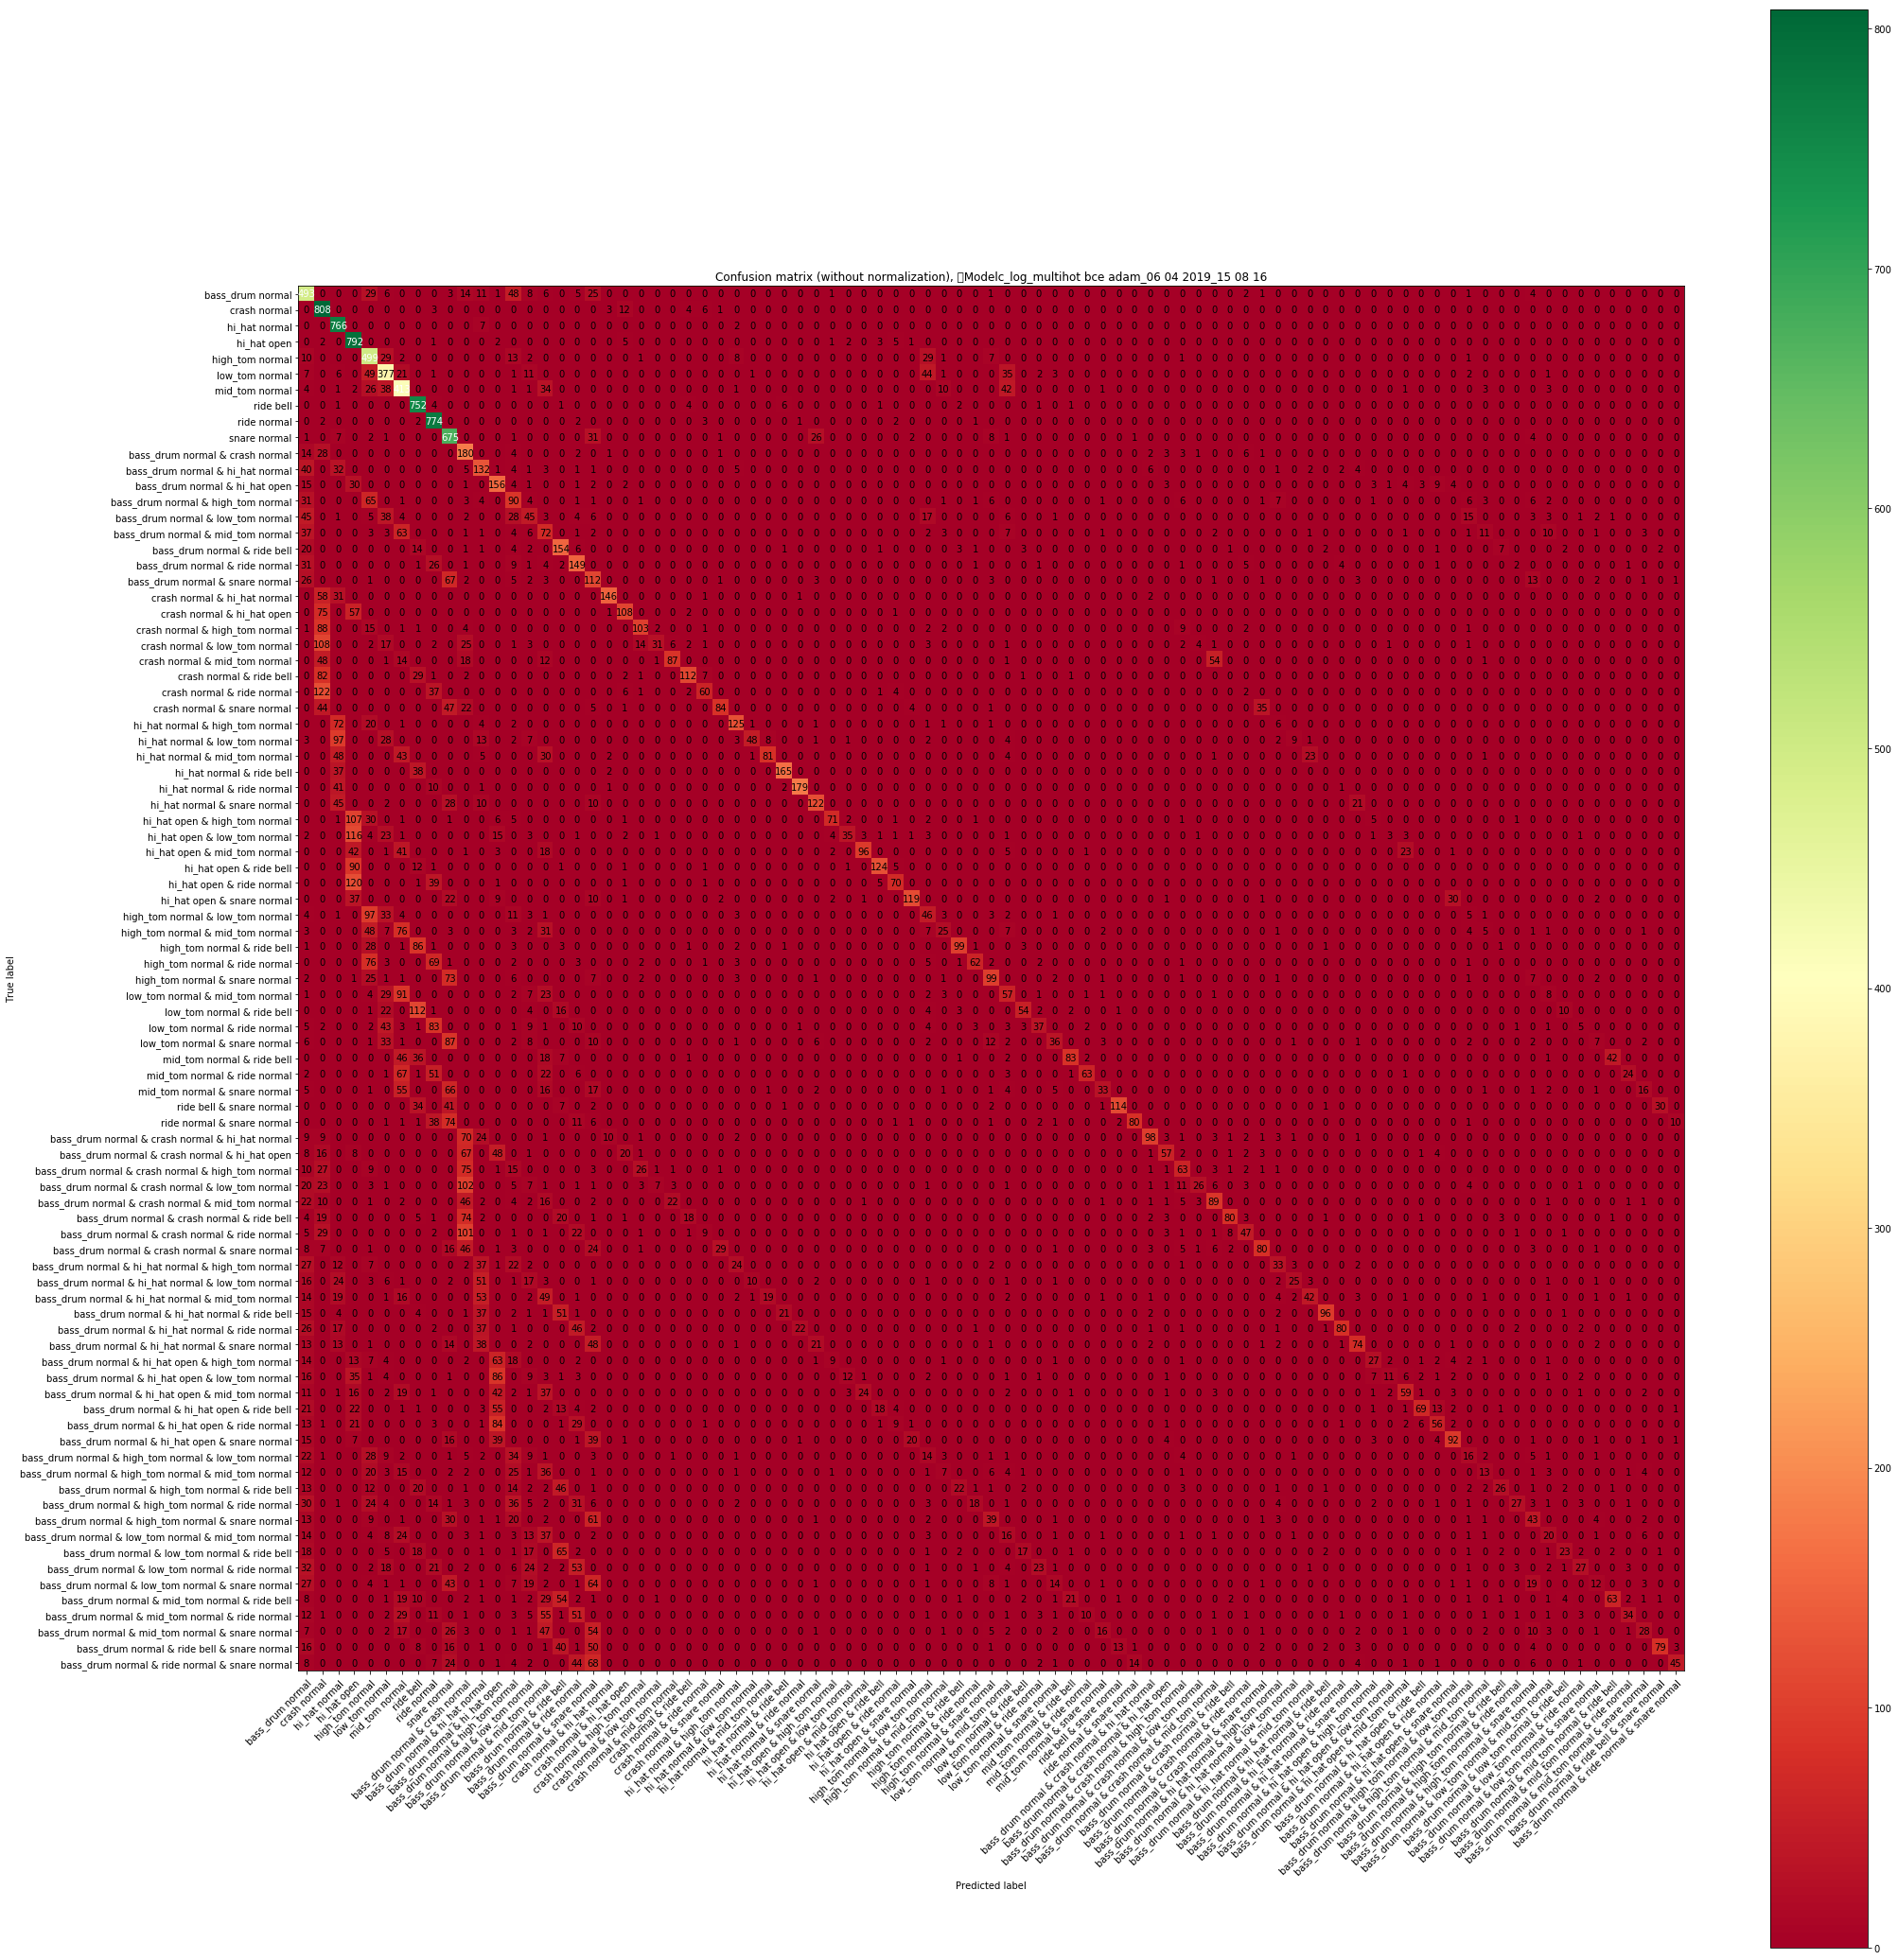

Normalized confusion matrix


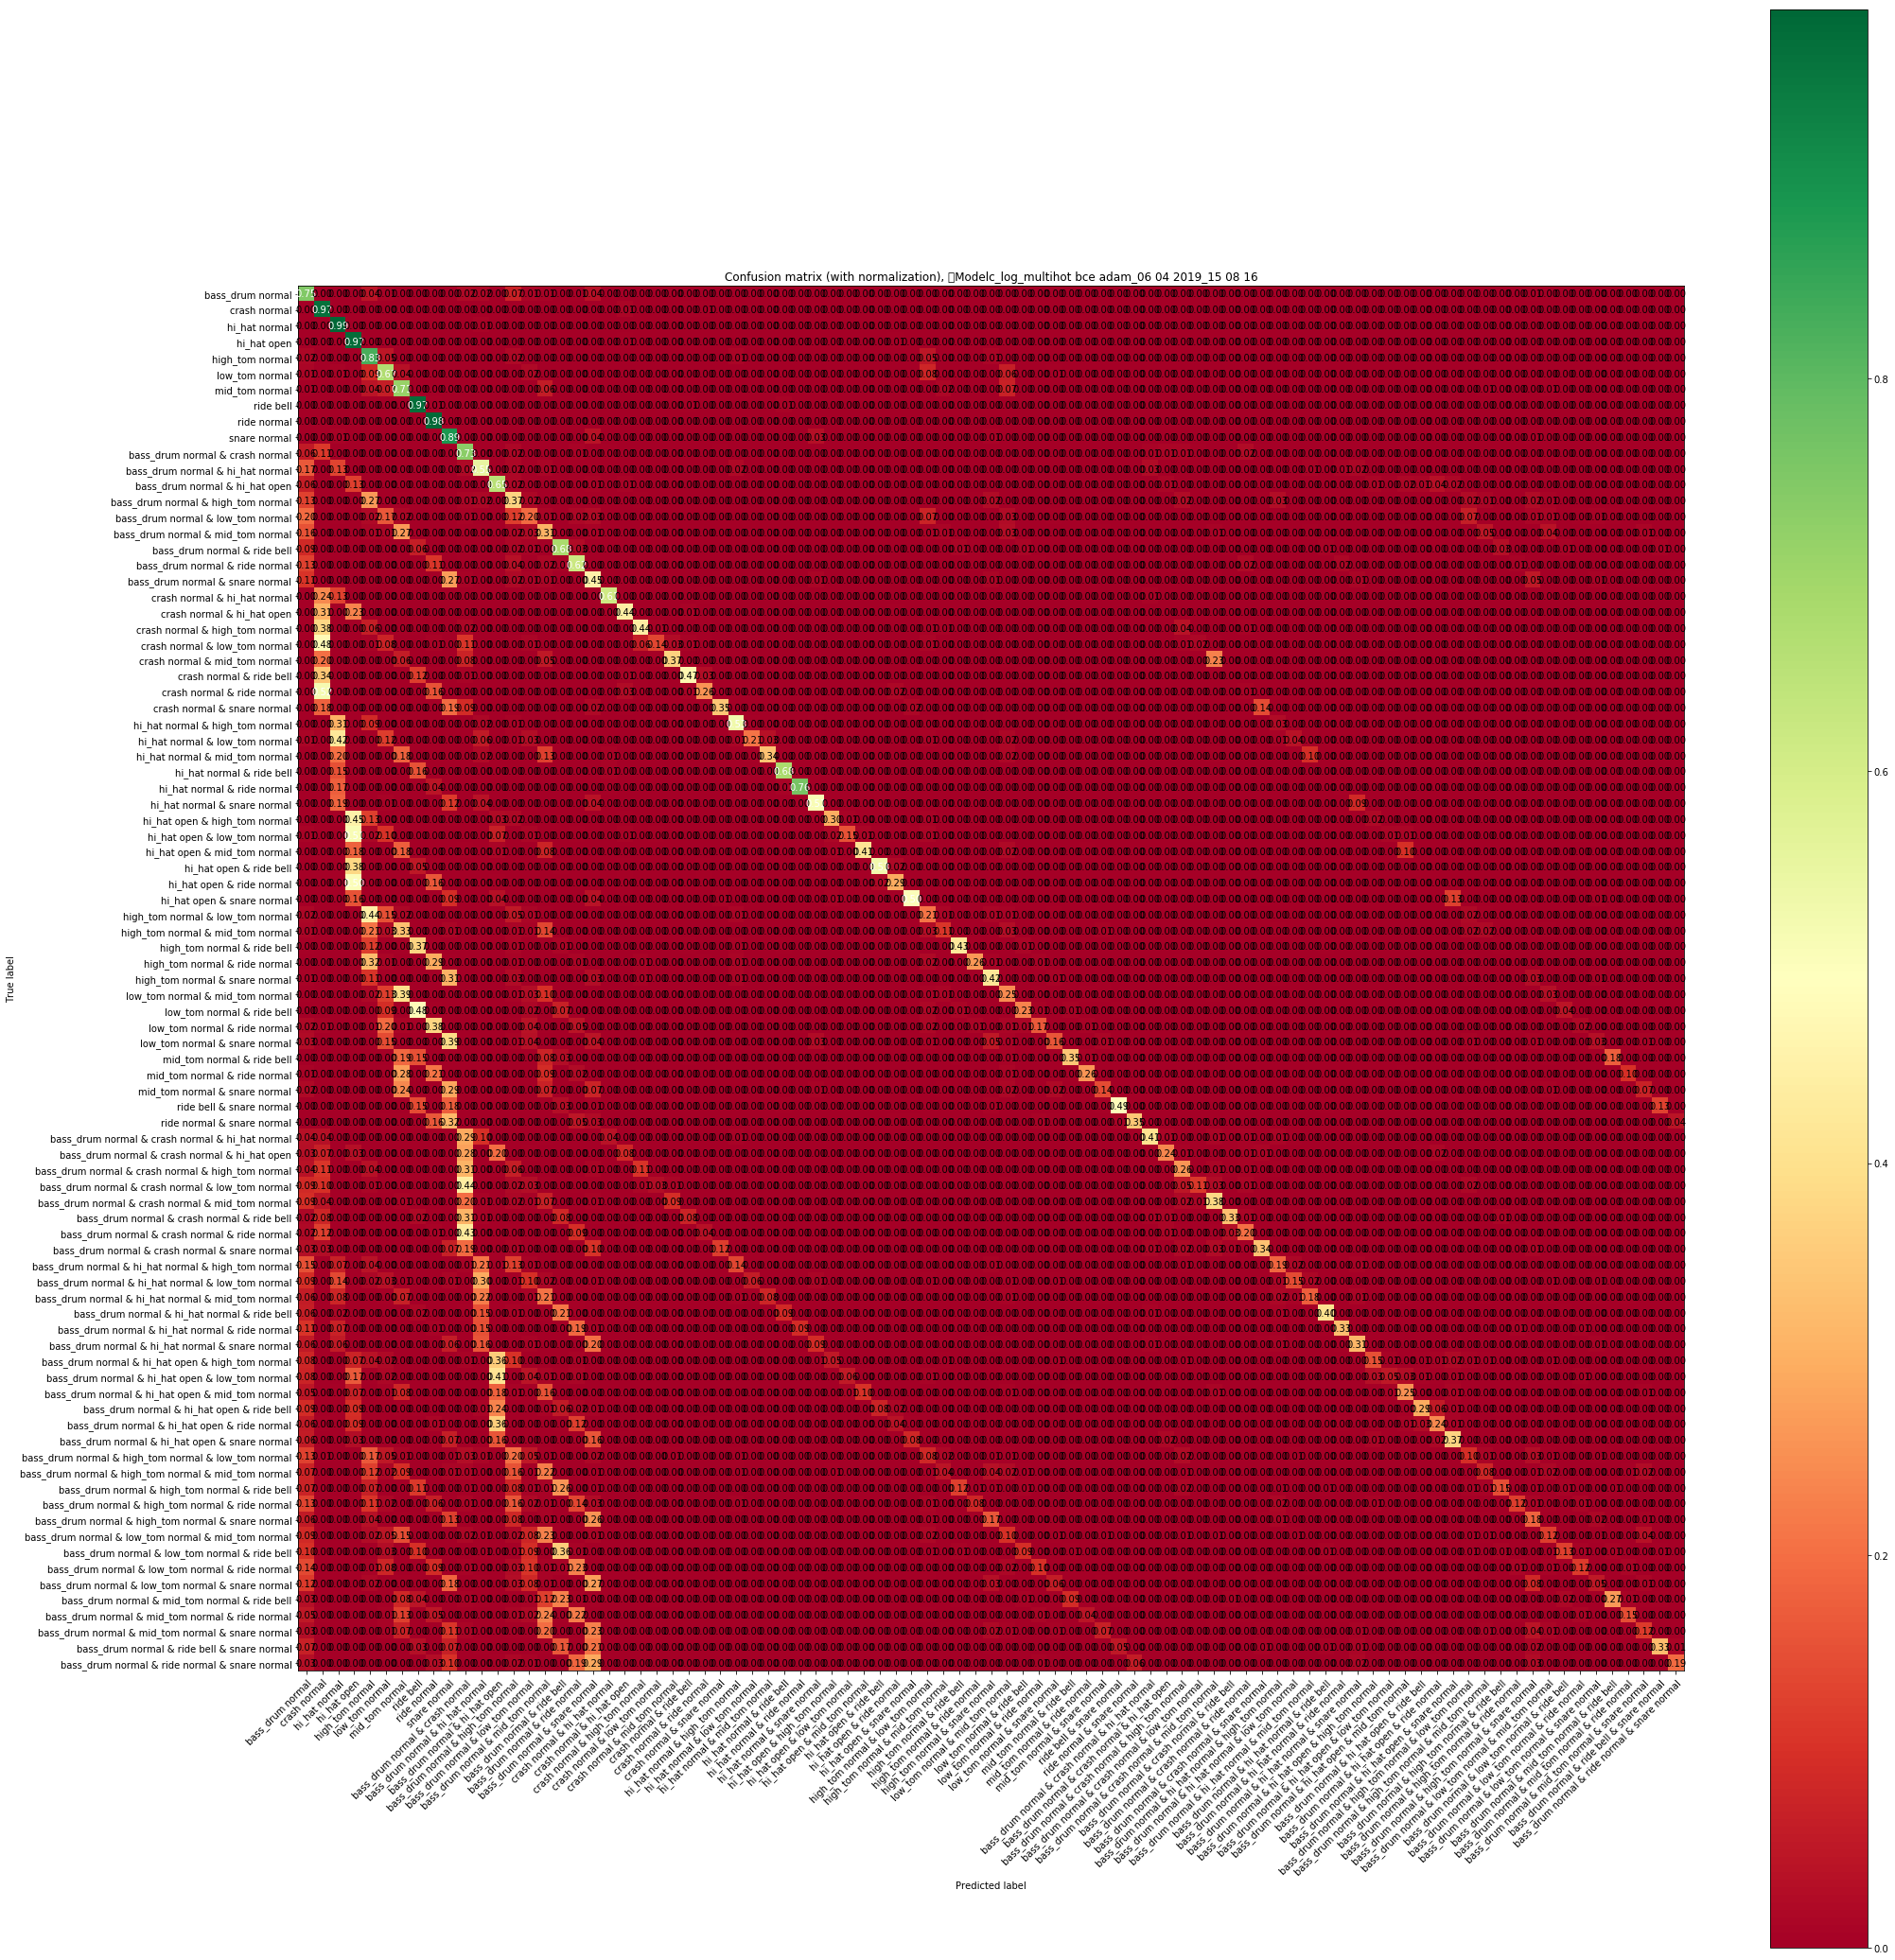

Unclassified data: 1678


In [32]:
formatted_name = re.sub("-", " ", " ".join(model_name.split("_")[:-2])).capitalize()

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=np.array(kcs_strings),
                      title='Confusion matrix (without normalization), \t{}'.format(formatted_name))

# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=np.array(kcs_strings), normalize=True,
                      title='Confusion matrix (with normalization), \t{}'.format(formatted_name))

print("Unclassified data: {}".format(unclassified))